# FAMLY Bias metrics example usage

In [1]:
from famly.bias.report import *
from famly.util.dataset import Datasets, german_lending_readable_values


Get the [german lending dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). Transform the values to human readable strings from the dataset description. Dataset is functionally equivalent.


In [2]:
datasets = Datasets()
df = german_lending_readable_values(datasets('german_lending').train())
df.shape

(1000, 21)

In [3]:
df.head()

,CheckingAC_Status,MaturityMonths,CreditHistory,Purpose,LoanAmount,SavingsAC,Employment,InstalmentPctOfIncome,SexAndStatus,OtherDebts,...,Property,Age,OtherInstalmentPlans,Housing,NumExistingLoans,Job,Dependents,Telephone,ForeignWorker,target
0,x < 0 DM,6,critical accnt. / other credits,radio/tv,1169,unknown,x >= 7 years,4,male single,none,...,real estate,67,none,own,2,skilled employee / official,1,yes,yes,1
1,0 <= x < 200 DM,48,existing credits paid,radio/tv,5951,x < 100 DM,1 <= x < 4 years,2,female divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,0
2,no checking account,12,critical accnt. / other credits,education,2096,x < 100 DM,4 <= x < 7 years,2,male single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,1
3,x < 0 DM,42,existing credits paid,forniture,7882,x < 100 DM,4 <= x < 7 years,2,male single,guarantor,...,soc. savings / life insurance,45,none,for free,1,skilled employee / official,2,none,yes,1
4,x < 0 DM,24,delay,new car,4870,x < 100 DM,1 <= x < 4 years,3,male single,none,...,unknown,53,none,for free,2,skilled employee / official,2,none,yes,0


In [55]:
cat_features = df.select_dtypes(include='category').columns
numeric_features = df.select_dtypes(include='number').columns

In [51]:
import seaborn as sns

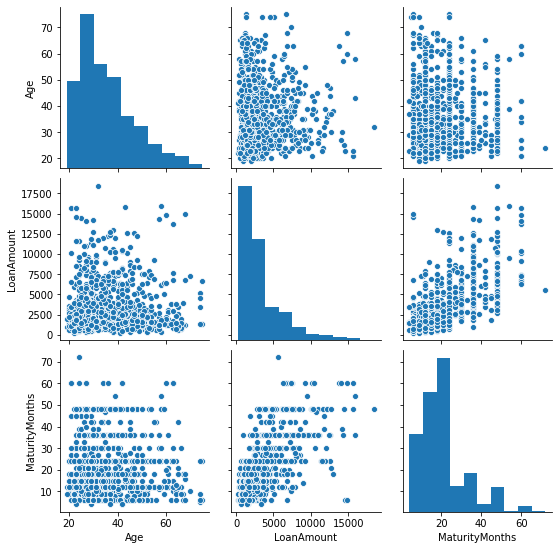

In [57]:
sns.pairplot(df[['Age','LoanAmount','MaturityMonths']])

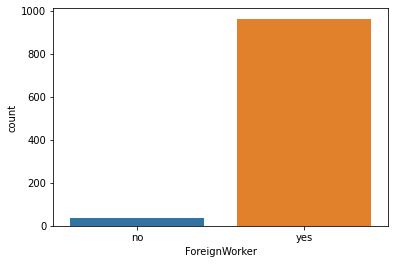

In [72]:
sns.countplot(df['ForeignWorker'])

## Calculate pre-training bias metrics

In [73]:
# Measure bias when the attribute ForeignWorker is true.
facet_column = FacetCategoricalColumn('ForeignWorker')

In [74]:
report = bias_report(df, facet_column, 'target')

In [75]:
report

{'CI': {'yes': -0.926, 'no': 0.926}}

## Train a CatBoost classifier

In [8]:
from catboost import Pool, CatBoostClassifier


In [9]:
from sklearn.model_selection import train_test_split


In [10]:
column_names = df.columns
train_cols= list(set(column_names) - set(['target']))
train, test = train_test_split(df, random_state=0)


In [11]:
train_df = train[train_cols]
test_df = test[train_cols]
train_labels = train['target']
test_labels = test['target']


In [12]:
test_pool = Pool(data=test_df, label=test_labels, cat_features=cat_features)
train_pool = Pool(data=train_df, label=train_labels, cat_features=cat_features)
model = CatBoostClassifier(iterations=10, learning_rate=1, depth=2)
model.fit(train_pool,verbose=True)



0:	learn: 0.5574538	total: 53.4ms	remaining: 481ms
1:	learn: 0.5311581	total: 55.9ms	remaining: 223ms
2:	learn: 0.5148538	total: 58.4ms	remaining: 136ms
3:	learn: 0.5047764	total: 61ms	remaining: 91.5ms
4:	learn: 0.5036185	total: 63.2ms	remaining: 63.2ms
5:	learn: 0.5030575	total: 65.5ms	remaining: 43.6ms
6:	learn: 0.4893152	total: 67.9ms	remaining: 29.1ms
7:	learn: 0.4803261	total: 70ms	remaining: 17.5ms
8:	learn: 0.4703191	total: 72ms	remaining: 8ms
9:	learn: 0.4681440	total: 74ms	remaining: 0us


In [13]:
def plot_roc_curve(labels, p_pos_label):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    fpr, tpr, thrs = roc_curve(labels, p_pos_label)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
y_test = model.predict_proba(test_pool)

In [15]:
test_labels_binary=test_labels.to_numpy()


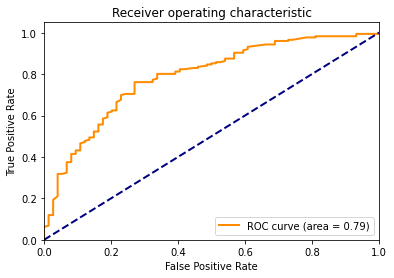

In [16]:
plot_roc_curve(test_labels_binary, y_test[:,1])

In [17]:
len(model.feature_importances_)


20

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [19]:
housing = train_df['Housing'].to_numpy()
housing = housing.reshape(-1,1)

In [20]:
def onehot(df, cat_features) -> pd.DataFrame:
    enc = OneHotEncoder(sparse=False)
    enc.fit(df[cat_features])
    res = enc.transform(df[cat_features])
    encoded_feature_names = enc.get_feature_names(cat_features)
    df_onehot = pd.DataFrame(res, columns=encoded_feature_names, index=df.index)
    other_features = list(set(df.columns)-set(cat_features))
    df_onehot = pd.concat([df_onehot, df[other_features]], axis=1)
    df_onehot[other_features] = df[other_features]
    return df_onehot

In [21]:
train_df_onehot = onehot(train_df, cat_features)

In [22]:
test_df_onehot = onehot(test_df, cat_features)

In [23]:
test_df_onehot.head()

,CheckingAC_Status_0 <= x < 200 DM,CheckingAC_Status_no checking account,CheckingAC_Status_x < 0 DM,CheckingAC_Status_x >= 200DM,CreditHistory_all credits paid,CreditHistory_critical accnt. / other credits,CreditHistory_delay,CreditHistory_existing credits paid,CreditHistory_no credits,OtherDebts_co-applicant,...,Job_skilled employee / official,Job_unemployed / unskilled-non-resident,Job_unskilled-resident,PresentResidenceYears,Dependents,LoanAmount,MaturityMonths,NumExistingLoans,InstalmentPctOfIncome,Age
993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3,1,3959,36,1,4,30
859,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,2,2,3577,9,1,1,26
298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,4,1,2515,18,1,3,43
553,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1,1,1995,12,1,4,27
672,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4,1,10366,60,1,2,42


In [24]:
assert train_df_onehot.isnull().sum().sum()==0
assert test_df_onehot.isnull().sum().sum()==0

In [25]:
model = LogisticRegression()

In [26]:
model.fit(train_df_onehot, train_labels)

/home/piotr/devel/thundera/famly/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [27]:
y_pred_lr = model.predict_proba(test_df_onehot)

In [28]:
test_labels

993    1
859    1
298    1
553    1
672    1
      ..
462    1
356    1
2      1
478    1
695    1
Name: target, Length: 250, dtype: category
Categories (2, int64): [0, 1]

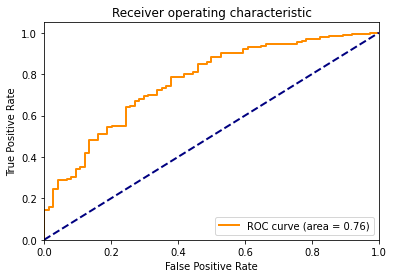

In [29]:
plot_roc_curve(test_labels, y_pred_lr[:,1])

In [42]:
model.coef_

array([[-2.73344878e-01,  1.09312663e+00, -7.99324998e-01,
         2.37122053e-01, -3.67233544e-01,  7.20806761e-01,
         2.65490328e-02,  3.22422261e-01, -4.44965705e-01,
        -1.75645417e-01,  3.99489605e-01,  3.37346172e-02,
        -1.51810093e-01,  4.97627284e-01, -8.82383849e-02,
        -4.95823142e-02, -1.21278964e-01, -2.37793229e-01,
         1.75082607e-01, -6.30189235e-01,  2.29924912e-02,
         4.00006726e-01, -1.30869313e-01,  7.19271345e-02,
         7.57282903e-01,  2.59258497e-01, -1.67969121e-03,
        -1.69311111e-01,  1.88755787e-02,  5.77969181e-01,
        -3.00694817e-01,  1.30739974e-01, -3.70249288e-02,
         2.94603735e-01,  1.45065018e-01,  2.83851395e-01,
        -1.71337606e-01,  2.89477851e-02, -1.46434610e-01,
         1.27660977e-01,  2.47404654e-01,  3.10308630e-02,
         4.19357007e-01,  1.16913470e-01, -4.06252511e-01,
         9.65299765e-02, -2.14275577e-01,  7.21901935e-01,
        -3.59983719e-02, -2.14049180e-01, -2.01341485e-0

In [39]:
test_df_onehot.shape

(250, 61)